In [1]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
from functools import partial

import parafields
import ilupp

import numpy as np
import scipy.sparse as sp
from scipy.sparse import spdiags, dia_matrix, tril, coo_matrix
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import device_put, random, vmap, jit, lax
import jax
from jax.experimental import sparse as jsparse

import optax
import equinox as eqx
from equinox.nn import Conv1d

In [3]:
def fd_mtx2(a):
    """
    Finite difference approximation of a 2D scalar diffusion equation in QTT.
    This function creates a finite difference Laplacian matrix with Dirichlet boundary conditions.
    """
    n = a.shape[0] - 1  # The coefficient is (n+1)x(n+1)

    # Initialize arrays
    ad = np.zeros((n, n))
    for i in range(n-1):
        for j in range(n):
            ad[i, j] = 0.5 * (a[i+1, j] + a[i+1, j+1])

    au = np.zeros((n, n))
    au[1:n, :] = ad[0:n-1, :]

    al = np.zeros((n, n))
    for i in range(n):
        for j in range(n-1):
            al[i, j] = 0.5 * (a[i, j+1] + a[i+1, j+1])

    ar = np.zeros((n, n))
    ar[:, 1:n] = al[:, 0:n-1]

    ac = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            ac[i, j] = a[i, j] + a[i, j+1] + a[i+1, j] + a[i+1, j+1]

    # Flatten arrays and combine into matrix
    bar_a = np.column_stack((-al.flatten("F"), -ad.flatten("F"), ac.flatten("F"), -au.flatten("F"), -ar.flatten("F")))

    # Create diagonal offsets for the sparse matrix
    offsets = [-n, -1, 0, 1, n]

    # Create the sparse matrix using spdiags
    mat = spdiags(bar_a.T, offsets, n*n, n*n)

    # Multiply by scaling factor (n+1)^2
    mat = mat * (n + 1) ** 2

    return mat.tocsc()

def div_k_grad(n_samples, grid, cov_model, var, tril_func, rhs_func=lambda grid: np.random.randn(grid*grid)):
    A_ls, L_ls, b_ls, x_ls, k_ls = [], [], [], [], []
    for _ in range(n_samples):
        field = parafields.generate_field(cells=[grid+1, grid+1], covariance=cov_model, variance=var)
        k = field.evaluate()
        dk = k.max() - k.min()
        A = fd_mtx2(np.exp(k))
        k_ls.append(np.exp(dk))
        
        b = rhs_func(grid)
        x = sp.linalg.spsolve(A, b)
        L = tril_func(A)
        
        A_ls.append(jsparse.BCOO.from_scipy_sparse(A.tocoo())[None, ...])
        L_ls.append(jsparse.BCOO.from_scipy_sparse(L.tocoo())[None, ...])
        b_ls.append(jnp.asarray(b))
        x_ls.append(jnp.asarray(x))
    
    A_ls = device_put(jsparse.bcoo_concatenate(A_ls, dimension=0))
    L_ls = device_put(jsparse.bcoo_concatenate(L_ls, dimension=0))
    b_ls = device_put(jnp.stack(b_ls, axis=0))
    x_ls = device_put(jnp.stack(x_ls, axis=0))
    print(f'Average k contrast: {np.mean(k_ls):.0f}')
    return A_ls, L_ls, b_ls, x_ls

def factorsILUp(A, p):
    l, u = ilupp.ilu0(A)
    for _ in range(p):
        lu = l @ u
        lu.data = np.clip(lu.data, a_min=1e-15, a_max=None)
        l, u = ilupp.ilu0(lu)
    return l, u

In [4]:
## DO NOT RUN THIS CELL

# grid = 32
# A_val, _, b_val, x_val = div_k_grad(1, grid, 'gaussian', .5, lambda A: tril(A))
# jnp.savez('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/inplace_mat_upd/val'+str(grid), Aval=A_val.data, Aind=A_val.indices, b=b_val, x=x_val)

In [5]:
# tril_func = lambda A: tril(A)
tril_func = lambda A: factorsILUp(A, 0)[0]

A_train, L_train, b_train, x_train = div_k_grad(1000, 128, 'gaussian', .5, tril_func)
A_test, L_test, b_test, x_test = div_k_grad(200, 128, 'gaussian', .5, tril_func)

2024-05-06 10:41:02.509973: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Average k contrast: 119
Average k contrast: 128


In [6]:
from typing import Callable, Union, Iterable
import jax.nn as jnn

class FullyConnectedNet(eqx.Module):
    layers: list
    act: Callable = eqx.field(static=True)
        
    def __init__(self, features, N_layers, key, act=jnn.relu, layer_=eqx.nn.Conv1d):
        super(FullyConnectedNet, self).__init__()
        N_in, N_pr, N_out = features
        keys = random.split(key, N_layers)
        Ns = [N_in,] + [N_pr,] * (N_layers - 1) + [N_out,]
        self.layers = [layer_(in_channels=N_in, out_channels=N_out, kernel_size=1, key=key) for N_in, N_out, key in zip(Ns[:-1], Ns[1:], keys)]
        self.act = act
        return
    
    def __call__(self, x):
        for l in self.layers[:-1]:
            x = l(x)
            x = self.act(x)
        x = self.layers[-1](x)
        return x

class InplaceTril(eqx.Module):
    DecoderL: eqx.Module
    def __init__(self, DecoderL):
        super(InplaceTril, self).__init__()
        self.DecoderL = DecoderL
        return
    
    def __call__(self, L, system_size):
        Lval = self.DecoderL(L.data[None, ...])[0, ...]
        L = jsparse.BCOO((Lval, L.indices), shape=(system_size, system_size))
        return L
    
@jsparse.sparsify
def llt_loss(L, b, x):
    return jnp.square(jnp.linalg.norm(L @ (L.T @ x) - b, ord=2))

def compute_loss(model, X):
    L, b, x = X[0], X[1], X[2]
    L = vmap(model, in_axes=(0, None), out_axes=(0))(L, b.shape[-1])
    loss = vmap(llt_loss, in_axes=(0, 0, 0), out_axes=(0))(L, b, x)
    return loss.mean()

In [7]:
def params_count(model):
    return sum([2*i.size if i.dtype == jnp.complex128 else i.size for i in jax.tree_util.tree_leaves(eqx.filter(model, eqx.is_array))])

def batch_indices(key, arr, batch_size):
    dataset_size = len(arr)
    batch_indices = random.choice(key, jnp.arange(dataset_size, dtype=jnp.int64), shape=[dataset_size // batch_size, batch_size])
    return batch_indices

In [8]:
lr = 1e-2
epoch_num = 800
batch_size = 32

train_config = {
    'optimizer': optax.adam,
    'lr': lr,
    'optim_params': {},#{'weight_decay': 1e-8}, 
    'epoch_num': epoch_num,
    'batch_size': batch_size
}

DecoderL = FullyConnectedNet(features=[1, 16, 1], N_layers=2, key=random.PRNGKey(42), layer_=Conv1d)
model = InplaceTril(DecoderL)
params_count(model)

49

In [9]:
def train(model, X_train, X_test, train_config, key=42, repeat_step=1):
    assert isinstance(train_config, dict)
    assert isinstance(X_train, Iterable)
    assert isinstance(X_test, Iterable)
    
    optim = train_config['optimizer'](train_config['lr'], **train_config['optim_params'])
    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    bacth_size = train_config['batch_size']
    assert len(X_train[1]) >= bacth_size, 'Batch size is greater than the dataset size'
    
    compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)
    
    def make_step(carry, ind):
        model, opt_state = carry
        batched_X = [arr[ind, ...] for arr in X_train]
        
        loss, grads = compute_loss_and_grads(model, batched_X)
        updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
        model = eqx.apply_updates(model, updates)
        return (model, opt_state), loss
    
    def make_val_step(model, X):
        return compute_loss(model, X)
    
    def train_body(carry, x):
        model, opt_state = carry
        key = random.PRNGKey(x)
        b = batch_indices(key, X_train[0], bacth_size)
        
        carry_inner_init = (model, opt_state)
        (model, opt_state), loss_train = lax.scan(make_step, carry_inner_init, b)
        loss_test = make_val_step(model, X_test)
        return (model, opt_state), [jnp.mean(loss_train), loss_test] 
    
    carry_init = (model, opt_state)
    (model, _), losses = lax.scan(train_body, carry_init, jnp.arange(train_config['epoch_num']))
    return model, losses

In [10]:
model, losses = train(model, [L_train, b_train, x_train], [L_test, b_test, x_test], train_config)

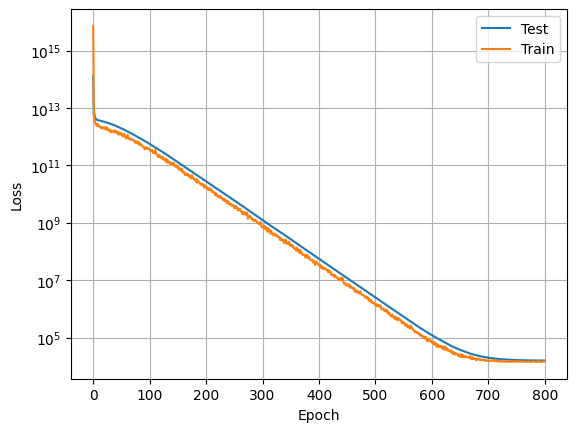

In [11]:
plt.plot(range(len(losses[0])), losses[1], label='Test')
plt.plot(range(len(losses[0])), losses[0], label='Train')

plt.legend()
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss');
plt.grid();

In [12]:
def nonlocal_iterate(arr):
    global iters
    iters += 1

iters = 0

def solve_prec(L, x):
    #(LL')^{-1} x
    LTinvx = sp.linalg.spsolve_triangular(L, x, lower=True)
    res = sp.linalg.spsolve_triangular(L.T, LTinvx, lower=False)
    return res

def jBCOO_to_scipyCSR(A):
    return coo_matrix((A.data, (A.indices[:, 0], A.indices[:, 1])), shape=A.shape, dtype=np.float64).tocsr()

In [ ]:
from scipy.sparse.linalg import LinearOperator, cg

# Run single val model
valid = jnp.load('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/inplace_mat_upd/val128.npz')
A = coo_matrix((valid['Aval'][0, ...], (valid['Aind'][0, :, 0], valid['Aind'][0, :, 1])), shape=L_test[0, ...].shape, dtype=np.float64).tocsr()
b = np.asarray(valid['b'][0, ...])
L = jsparse.BCOO.from_scipy_sparse(tril_func(A).tocoo())
L = jBCOO_to_scipyCSR(model(L, b.shape[-1]))

iters = 0
prec_opt = LinearOperator(A.shape, lambda x: x)
solution, info = cg(A, b, M=prec_opt, tol=1e-6, callback=nonlocal_iterate)
print(f'CG: {iters}')

iters = 0
prec_opt = LinearOperator(A.shape, lambda x: solve_prec(L, x))
solution, info = cg(A, b, M=prec_opt, tol=1e-6, callback=nonlocal_iterate, maxiter=920)
print(f'PCG: {iters}')

CG: 920
